In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
%matplotlib inline

# Bring in the Observed (UNSODA) data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [2]:
CondData = pd.read_excel('.\Data\lab_drying_h-k.xlsx') # in cm/d
ThetaData = pd.read_excel('.\Data\lab_drying_h-t.xlsx') # in cm3/cm3
PropertiesData = pd.read_excel('.\Data\SoilProperties.xlsx')
PropertiesData.set_index('code',inplace=True)

### Join h, k and t data into a single data frame and have a quick look

In [3]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [4]:
Data = MergedData.dropna()

In [5]:
Data.set_index('code',inplace=True,drop=False)

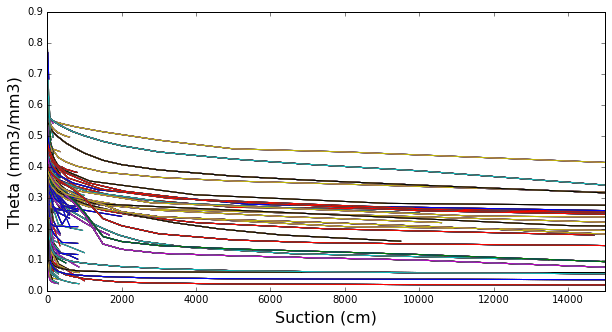

In [6]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

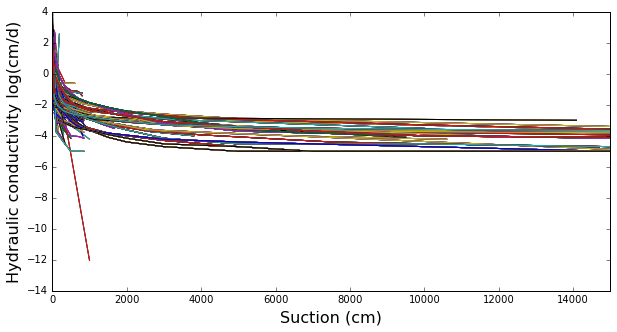

In [7]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log10(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(cm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


### Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
### Filter out anything that has a narrow range of measurements

In [8]:
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [10]:
FullData = Data.ix[SetFilter,:].copy()

### Convert conductivity data to mm/h and potentials to mmH2O

In [11]:
condcmd = FullData.ix[:,'conductivity']
prescm = FullData.ix[:,'preshead']
Ksatcmd = PropertiesData.ix[:,'k_sat']
FullData.ix[:,'conductivity'] = condcmd*10/24
FullData.ix[:,'preshead'] = prescm * 10
PropertiesData.ix[:,'k_sat'] = Ksatcmd *10/24

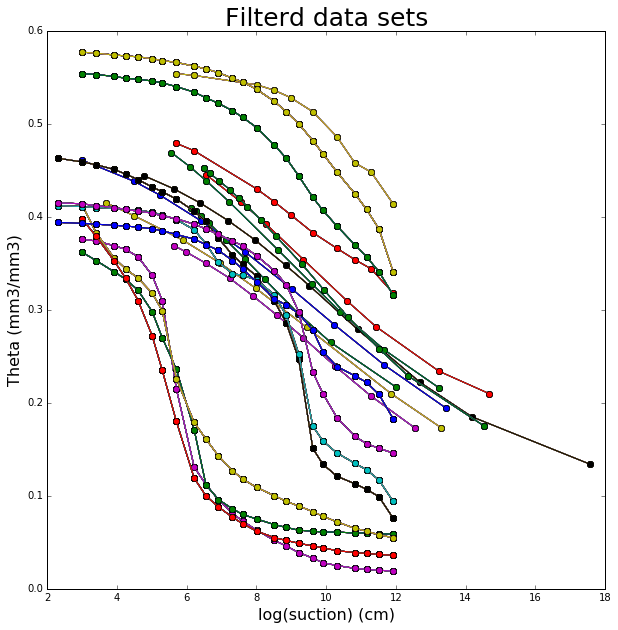

In [12]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (cm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


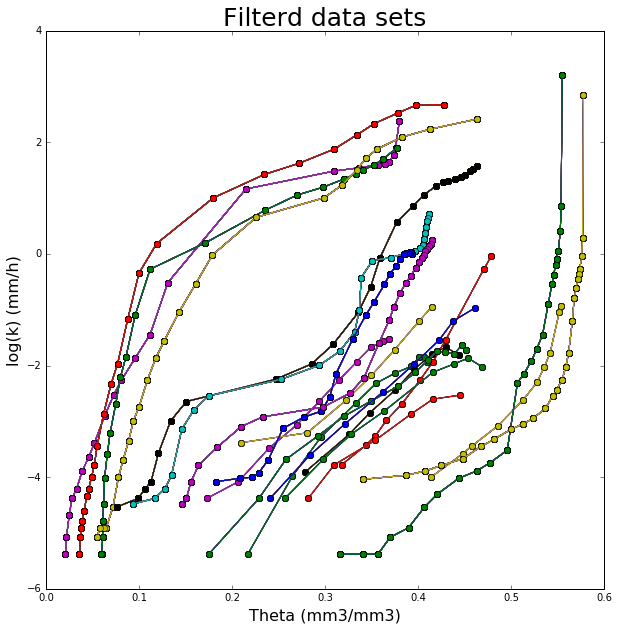

In [13]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log10(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (mm/h)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

## Now we have a data set we can work with lets calculate some things

### Index bits for a start

In [14]:
FullData.sort_values(by=['code','preshead'],inplace=True)

In [15]:
FullData.ix[:,'IntCode']=[x for x in range(FullData.index.size)]

In [16]:
FullData.ix[:,'SampleCode'] = 0

In [17]:
StartCode = 0
for x in FullData.index:
    code = range(StartCode,StartCode + FullData.ix[x,'SampleCode'].size)
    Soil = FullData.ix[x,'SampleCode'] = code

## Set up some arbitary pore compartments 

### assuming the largest compartments upper diameter is that of the lowest measured pressure and the lower diameter of the smallest pore is zero

In [18]:
FullData.set_index('IntCode',inplace=True)

In [19]:
# UpperDiameter units = um
FullData.ix[:,'UpperDiameter'] = 30000/FullData.ix[:,'preshead']

In [20]:
FullData.ix[:,'LowerDiameter'] = 0

In [21]:
def LowerDia(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'UpperDiameter']
        return ret_val

In [22]:
# LowerDiameter units = um
FullData.ix[:,'LowerDiameter'] = [LowerDia(x) for x in range(FullData.index.size)]

### The radius of each more compartment is the mean of its upper and lower diameters

In [23]:
# PoreRadius units = um
FullData.ix[:,'PoreRadius'] = np.add(FullData.ix[:,'UpperDiameter'],FullData.ix[:,'LowerDiameter'])/4

### The area of individual pore columns in each compartment is calcualted from its radius

In [24]:
# Area units = um2
FullData.ix[:,'Area'] = np.pi * np.power(FullData.ix[:,'PoreRadius'],2)

# Now lets set up equations for modelling moisture release and conductivity curves

### Set up arrays with the pore boundary settings

In [25]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSI =  np.divide(-30000,PoreBounds)

# Set up 5 point hermite spline for modelling moisture release curved between specified points

In [26]:
def HermiteSpline5pt(SAT,DUL,LL15,PSI,psis,psibub,psid,psi_ll15,psi0):
    #Determines spline parameters to interpolate between 
    #SAT, BUB, DUL, LL15 and Oven dry points on moisture release curve and
    #returns an array of volumetric water contents (mm3/mm3) for the 
    #tensions (PSI) input
    BUB = DUL + (SAT-DUL)*1#0.95
    DELk = [0] * 5
    DELk[0] = (BUB - (SAT+1e-20)) / (np.log10(-psibub))#Tiny amount added to Sat so in situations where DUL = SAT this function returns a non zero value
    DELk[1] = (DUL- BUB) / (np.log10(-psid) - np.log10(-psibub))
    DELk[2] = (LL15 - DUL) / (np.log10(-psi_ll15) - np.log10(-psid))
    DELk[3] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    DELk[4] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    
    Mk = [0] * 5
    Mk[0] = 0.0
    Mk[1] = (DELk[0] + DELk[1]) / 2.0
    Mk[2] = (DELk[1] + DELk[2]) / 2.0
    Mk[3] = (DELk[2] + DELk[3]) / 2.0
    Mk[4] = DELk[4]

    # First bit might not be monotonic so check and adjust
    alpha = Mk[0] / DELk[0]
    beta = Mk[1] / DELk[0]
    phi = alpha - (np.power(2.0 * alpha + beta - 3.0, 2.0) / (3.0 * (alpha + beta - 2.0)));
    if (phi <= 0):
        tau = 3.0 / np.sqrt(alpha * alpha + beta * beta)
        Mk[0] = tau * alpha * DELk[0]
        Mk[1] = tau * beta * DELk[0]

    M0 = [0] * 6
    M1 = [0] * 6
    Y0 = [0] * 6
    Y1 = [0] * 6

    M0[0] = 0.0;
    M1[0] = 0.0;
    Y0[0] = SAT;
    Y1[0] = SAT;
    
    M0[1] = Mk[0] * (np.log10(-psibub) - np.log10(-psis));
    M1[1] = Mk[1] * (np.log10(-psibub) - np.log10(-psis));
    Y0[1] = SAT;
    Y1[1] = BUB;

    M0[2] = Mk[1] * (np.log10(-psid) - np.log10(-psibub));
    M1[2] = Mk[2] * (np.log10(-psid) - np.log10(-psibub));
    Y0[2] = BUB;
    Y1[2] = DUL;

    M0[3] = Mk[2] * (np.log10(-psi_ll15) - np.log10(-psid));
    M1[3] = Mk[3] * (np.log10(-psi_ll15) - np.log10(-psid));
    Y0[3] = DUL;
    Y1[3] = LL15;

    M0[4] = Mk[3] * (np.log10(-psi0) - np.log10(-psi_ll15));
    M1[4] = Mk[4] * (np.log10(-psi0) - np.log10(-psi_ll15));
    Y0[4] = LL15;
    Y1[4] = 0.0;

    M0[5] = 0.0;
    M1[5] = 0.0;
    Y0[5] = 0.0;
    Y1[5] = 0.0;

    Thetas = []
    for psi in PSI:
        if (psi >= psis):
            i = 0;
            t = 0.0;
        elif (psi > psibub):
            i = 1
            t = (np.log10(-psi) - np.log10(-psis)) / (np.log10(-psibub) - np.log10(-psis));
        elif (psi > psid):
            i = 2;
            t = (np.log10(-psi) - np.log10(-psibub)) / (np.log10(-psid) - np.log10(-psibub));
        elif (psi > psi_ll15):
            i = 3;
            t = (np.log10(-psi) - np.log10(-psid)) / (np.log10(-psi_ll15) - np.log10(-psid));
        elif (psi > psi0):
            i = 4;
            t = (np.log10(-psi) - np.log10(-psi_ll15)) / (np.log10(-psi0) - np.log10(-psi_ll15));
        else:
            i = 5;
            t = 0.0;

        tSqr = t * t;
        tCube = tSqr * t;
        theta = (2 * tCube - 3 * tSqr + 1) * Y0[i] + (tCube - 2 * tSqr + t) * M0[i]\
                + (-2 * tCube + 3 * tSqr) * Y1[i] + (tCube - tSqr) * M1[i];
        Thetas.append(min(theta, SAT))#When Sat and DUL are very close, spline can produce number greater that sat
    return Thetas

In [27]:
def ThetaCurvemm5pt(SAT,DUL,LL15,PSI,psibub):
    ##Set up the tenstion points for spline, units in mm
    psis = -10
    psid = -1000
    psi0 = -0.6e8
    psi_ll15 = -150000.0;

    return HermiteSpline5pt(SAT,DUL,LL15,PSI,psis,psibub,psid,psi_ll15,psi0)

# Set up calculation procedure to calculate the conductivity curve of the soil from its theta curve.  

This is done as following Arya etal 1999

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

### Helper functions to calculate parameters for conductivity

In [28]:
def PsiLower(x,FitFrame):
    if x == 10:
        ret_val = -6.000000e+07
    else:
        ret_val = FitFrame.ix[x+1,'PsiUpper']
    return ret_val

def LowerDia(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x+1,'UpperDiameter']
    return ret_val

def thetaLower(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x+1,'ThetaUpper']
    return ret_val

def AccumCond(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x,'PoreCapillarity'] + FitFrame.ix[x+1,'Conductivity']
    return ret_val

### Function to create data frame containing soil geometric, porosity and hydraulic properties

In [29]:
def ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    # PsiUpper units = mmH2O
    FitFrame = pd.DataFrame(data=BoundPSI,columns = ['PsiUpper'])
    # PsiUpper units = mmH2O
    FitFrame.ix[:,'PsiLower'] = [PsiLower(x, FitFrame) for x in range(FitFrame.index.size)]
     # LowerDiameter Units = um
    FitFrame.ix[:,'UpperDiameter'] = -30000/FitFrame.ix[:,'PsiUpper']
     # LowerDiameter Units = um
    FitFrame.ix[:,'LowerDiameter'] = 0
    FitFrame.ix[:,'LowerDiameter'] = [LowerDia(x, FitFrame) for x in range(FitFrame.index.size)]
    # Radius units = um
    FitFrame.ix[:,'PoreRadius'] = (FitFrame.ix[:,'UpperDiameter']+FitFrame.ix[:,'LowerDiameter'])/4
    # Area units = um2
    FitFrame.ix[:,'PoreArea'] = np.pi * np.power(FitFrame.ix[:,'PoreRadius'],2)
    # ThetaUpper Units = mm3/mm3
    FitFrame.ix[:,'ThetaUpper'] = ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub)
    # ThetaLower Units = mm3/mm3
    FitFrame.ix[:,'ThetaLower'] = [thetaLower(x, FitFrame) for x in range(FitFrame.index.size)]
    # Volume Units = mm3/mm3
    FitFrame.ix[:,'Volume'] = FitFrame.ix[:,'ThetaUpper']-FitFrame.ix[:,'ThetaLower']
    # In cases where two point on the moisture release curve are close, the spline can
    # dip causing negative volumes.  Set these to zero
    FitFrame.ix[:,'Volume'].where(FitFrame.ix[:,'Volume']>0,0,inplace=True)
    # Number units = /m
    FitFrame.ix[:,'Number'] = np.divide(FitFrame.ix[:,'Volume'],np.divide(FitFrame.ix[:,'PoreArea'], 1000000000000))
    # PoreFlowRate units = mm3/s
    FitFrame.ix[:,'PoreFlowRate'] = Cflow * np.power(FitFrame.ix[:,'PoreRadius'],Xflow)
    # VolumetricFlowRate units = mm3/s/m2
    FitFrame.ix[:,'VolumetricFlow'] = FitFrame.ix[:,'PoreFlowRate'] * FitFrame.ix[:,'Number']
    # PoreCapilalarity units = mm/h
    FitFrame.ix[:,'PoreCapillarity'] = FitFrame.ix[:,'VolumetricFlow']/1e6*3600
    # Conductivity (of all pores) units = mm/h
    FitFrame.ix[:,'Conductivity'] = [0] * 11
    for x in reversed(range(FitFrame.index.size)):
        FitFrame.ix[x,'Conductivity'] = AccumCond(x, FitFrame)
    return FitFrame

### Functions to facilitate fitting of Cflow and Xflow parameters for each soil

In [30]:
def interpCond(x_new,Psi,cond):
    k = interp1d(np.log10(-Psi),np.log10(cond))
    return  k(np.log10(x_new))
    
def CalcConductivity(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,x):
    Calcs = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    return interpCond(x,Calcs.ix[:,'PsiUpper'],Calcs.ix[:,'Conductivity'])
    
def Condfun (x,Cflow,Xflow):
    return CalcConductivity(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,x)

### Create data frame for providing observed data for fitting

In [31]:
GraphData = FullData.set_index('code')

### Create data frame to take fitted values

In [32]:
SoilList = GraphData.index.drop_duplicates().values

In [33]:
Fits = pd.DataFrame(index = map(str,SoilList),
                    columns = ['SAT','DUL','LL','psibub','Cflow','Xflow','Ksat','kFC'])

### Make dataframe with soil properties for full set points

In [34]:
PropsDataFull = PropertiesData.ix[SoilList,:]
PropsDataFull.index = PropsDataFull.index.map(str)
PropsDataFull['EstPorosity'] = 1- np.divide(PropsDataFull.ix[:,'bulk_density'],PropsDataFull.ix[:,'particle_density'])

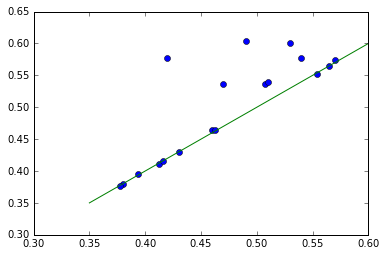

In [35]:
plt.plot(PropsDataFull.ix[:,'porosity'],PropsDataFull.ix[:,'EstPorosity'],'o')
plt.plot([0.35,0.6],[0.35,0.6])

In [36]:
PropsDataFull

,bulk_density,particle_density,porosity,OM_content,k_sat,theta_sat,CEC,pH,electrolyte_level,SAR,ESP,EC,free_Fe_Al_oxide,EstPorosity
2360,1.420,2.573,NaN,4.86,2.083333,0.492,NaN,6.9,NaN,NaN,NaN,NaN,NaN,0.448115
2362,1.250,2.652,NaN,2.15,0.166667,0.557,NaN,6.7,NaN,NaN,NaN,NaN,NaN,0.528658
4592,1.210,2.610,0.507,3.90,NaN,NaN,NaN,6.2,NaN,NaN,NaN,NaN,NaN,0.536398
4600,1.040,2.610,0.530,3.40,NaN,NaN,NaN,6.3,NaN,NaN,NaN,NaN,NaN,0.601533
4602,1.040,2.630,0.490,2.60,NaN,NaN,NaN,6.4,NaN,NaN,NaN,NaN,NaN,0.604563
4610,1.110,2.610,0.570,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574713
4611,1.110,2.630,0.540,3.10,NaN,NaN,NaN,6.4,NaN,NaN,NaN,NaN,NaN,0.577947
4612,1.110,2.630,0.420,3.10,NaN,NaN,NaN,6.4,NaN,NaN,NaN,NaN,NaN,0.577947
4620,1.210,2.610,0.470,3.90,NaN,NaN,NaN,6.2,NaN,NaN,NaN,NaN,NaN,0.536398
4622,1.210,2.630,0.510,3.20,NaN,NaN,NaN,6.2,NaN,NaN,NaN,NaN,NaN,0.539924


### Function to fit conductivity parameters for each soil

In [37]:
#Function to fit hudraulic conductivity components and graph results.
def FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0):
    GreaterThan0 = GraphData.ix[Set,'preshead']>0
    LessThan150000 = GraphData.ix[Set,'preshead']<150000
    NonExtremities = GreaterThan0 & LessThan150000
    
    Obs_x = GraphData.ix[Set,'preshead'][NonExtremities].values
    Obs_y = np.log10(GraphData.ix[Set,'conductivity'][NonExtremities].values)

    bounds = (lower, upper)
    res = curve_fit(Condfun, Obs_x, Obs_y, bounds=bounds, p0 = p0, method ='trf', loss = 'soft_l1',verbose = 1)

    Cflow = res[0][0]
    Xflow = res[0][1]

    FitFrame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow
    Fits.ix[Set,'kSat'] = FitFrame.ix[0,'Conductivity']
    Fits.ix[Set,'kFC'] = FitFrame.ix[5,'Conductivity']

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
    plt.plot([1],PropsDataFull.ix[Set,'EstPorosity'],'^',markersize = 10,label = 'Porosity')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,'Soil ID ' +Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'][GraphData.ix[Set,'preshead']>0].max()*2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.text(4,ymax*.8,'KSat = ' + '%.4g' % FitFrame.ix[0,'Conductivity'] + '\nKFC = ' + '%.4g' % FitFrame.ix[5,'Conductivity'],fontsize=16)
    plt.text(4,ymax*.65, 'KSatObs = ' + '%.4g' % PropsDataFull.ix[Set,'k_sat'],fontsize = 16)
    plt.ylim(0,ymax)
    plt.legend()

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'][NonExtremities].values,FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead'][NonExtremities].values),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    
    plt.legend()

In [38]:
#Function to fit hudraulic conductivity components and graph results.
import matplotlib.patches as patches
def ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    GreaterThan0 = GraphData.ix[Set,'preshead']>0
    LessThan150000 = GraphData.ix[Set,'preshead']<150000
    NonExtremities = GreaterThan0 & LessThan150000
    
    FitFrame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow
    Fits.ix[Set,'kSat'] = FitFrame.ix[0,'Conductivity']
    Fits.ix[Set,'kFC'] = FitFrame.ix[5,'Conductivity']

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
    plt.plot([1],PropsDataFull.ix[Set,'EstPorosity'],'^',markersize = 10,label = 'Porosity')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,'Soil ID ' +Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'][GraphData.ix[Set,'preshead']>0].max()*2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.text(4,ymax*.8,'KSat = ' + '%.4g' % FitFrame.ix[0,'Conductivity'] + '\nKFC = ' + '%.4g' % FitFrame.ix[5,'Conductivity'],fontsize=16)
    plt.text(4,ymax*.65, 'KSatObs = ' + '%.4g' % PropsDataFull.ix[Set,'k_sat'],fontsize = 16)
    plt.ylim(0,ymax)
    plt.legend()

    CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0,0,1,1])
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'][NonExtremities].values,FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead'][NonExtremities].values),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    
    plt.legend()

# Fit parameters
### Each cell below fits and graphs results for a single soil.  Moisture release points are fitted by eye to observed data to provide inputs for the hydraulic conductivit model and then Cflow and Xflow are optimised for each soil to predict hydraulic conductivity

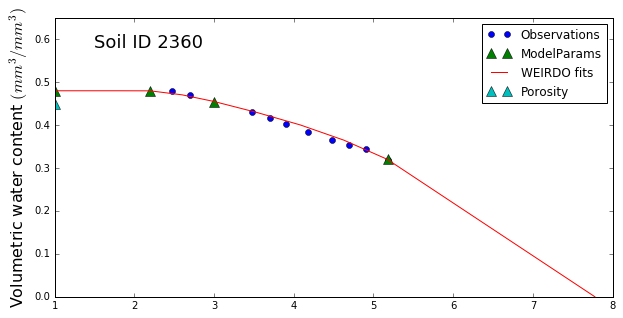

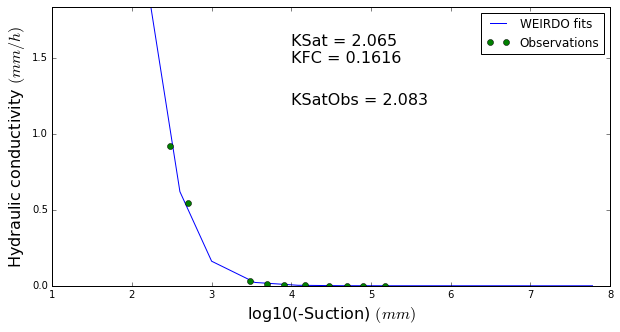

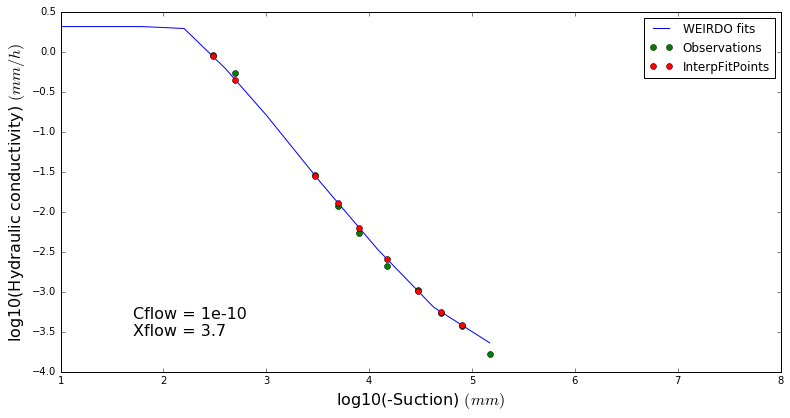

In [39]:
Set = '2360'
FitSAT = 0.48
FitDUL = 0.455
FitLL = 0.32
psibub = -155  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-10,3.7)

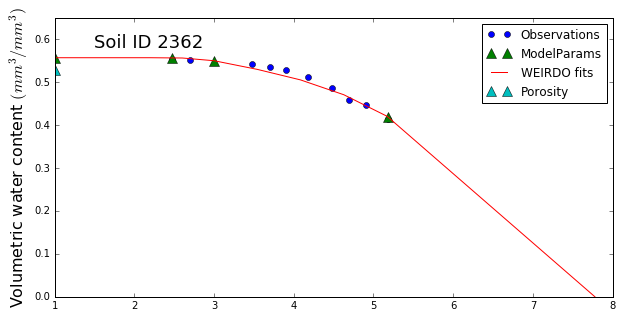

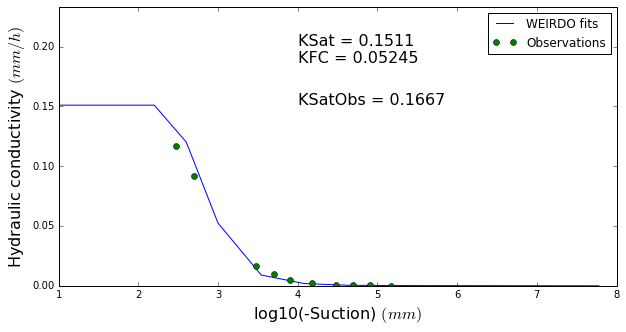

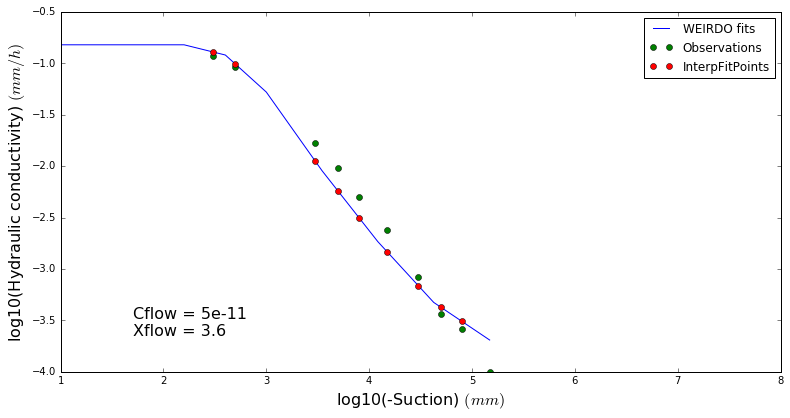

In [40]:
#Implementation Note.  When DUL is close to SAT psibub needs to be a bigger negative 
# or else the spline exceeds the value of SAT at some points, giving odd volumes
Set = '2362'
FitSAT = 0.557
FitDUL = 0.55
FitLL = 0.42
psibub = -300  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-10,1.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-11,3.6)

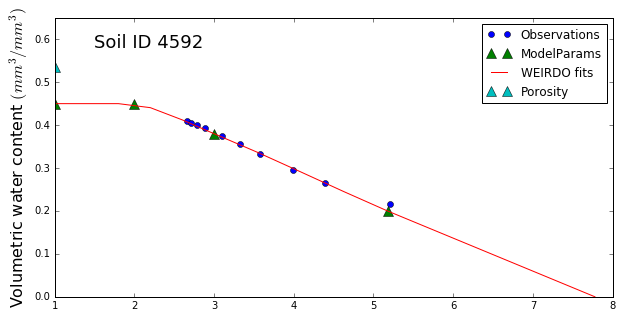

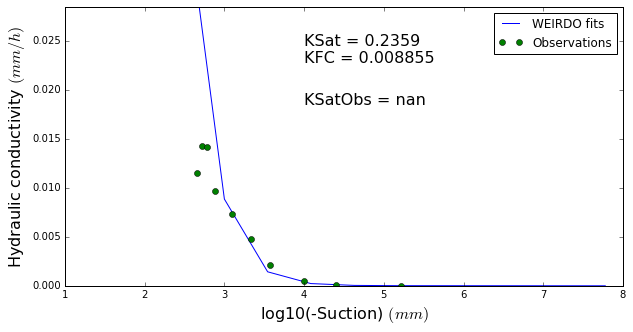

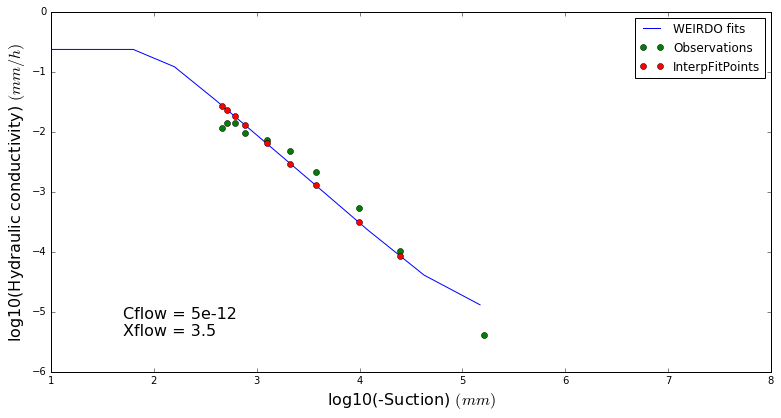

In [41]:
Set = '4592'
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibub = -100  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,5e-12,3.5)

`xtol` termination condition is satisfied.
Function evaluations: 15, initial cost: 4.3021e+00, final cost 2.1301e-01, first-order optimality 2.03e+05.


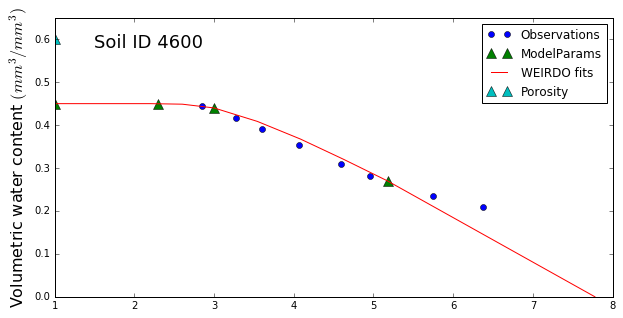

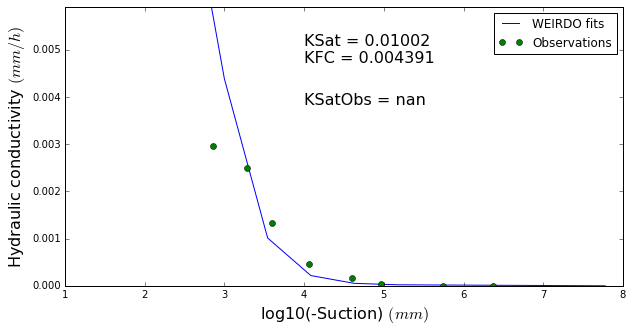

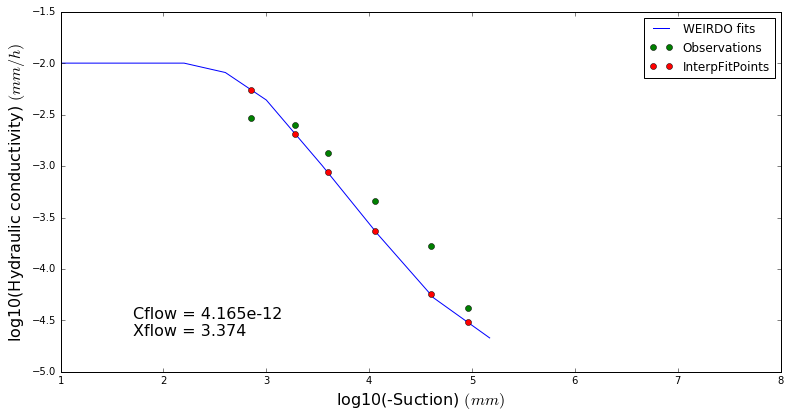

In [42]:
Set = '4600'
FitSAT = 0.45
FitDUL = 0.44
FitLL = 0.27
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,2.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

`xtol` termination condition is satisfied.
Function evaluations: 10, initial cost: 2.7217e+01, final cost 2.6208e-01, first-order optimality 6.09e+00.


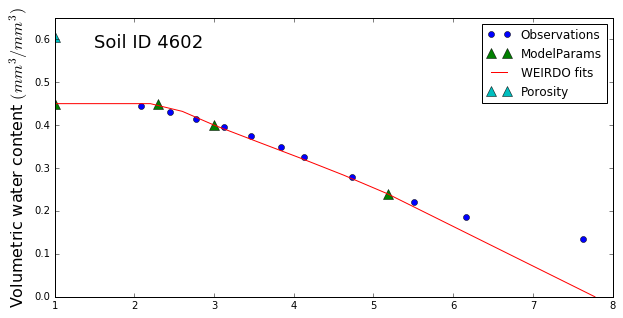

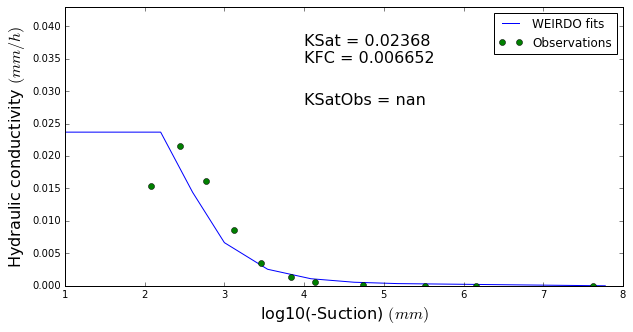

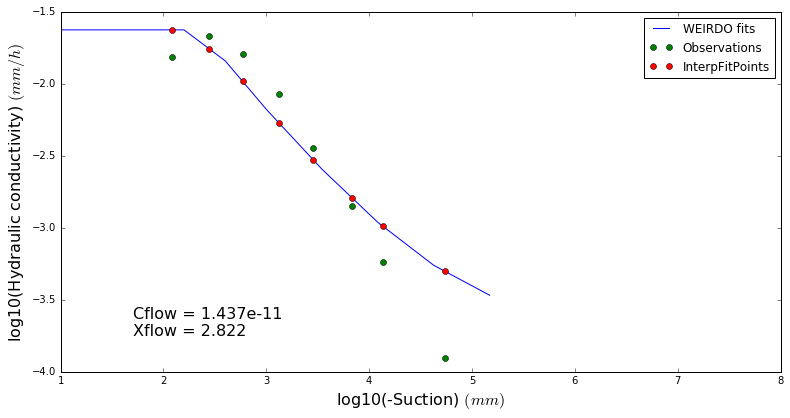

In [43]:
Set = '4602'
FitSAT = 0.45
FitDUL = 0.4
FitLL = 0.24
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-10,6.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

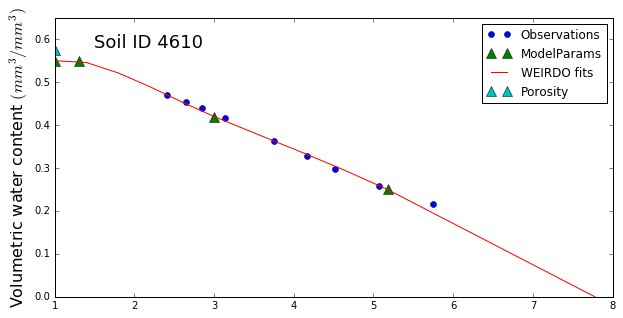

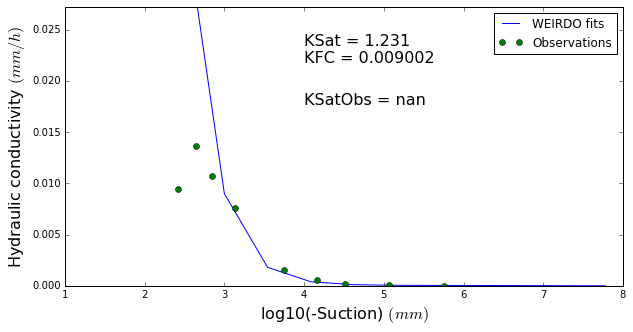

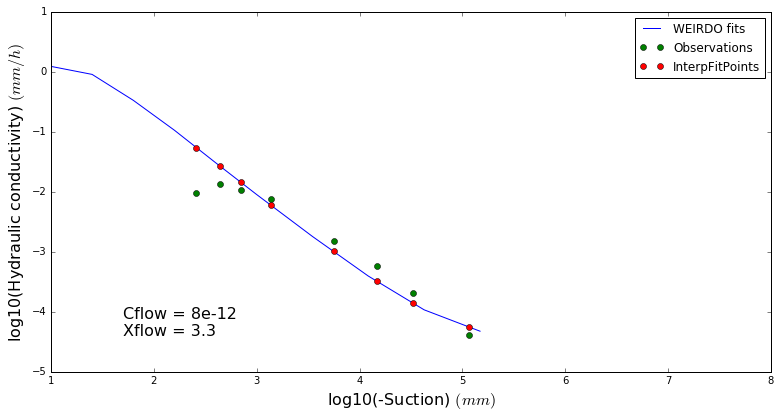

In [44]:
Set = '4610'
FitSAT = 0.55
FitDUL = 0.42
FitLL = 0.25
psibub = -20  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-12,5.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,8e-12,3.3)

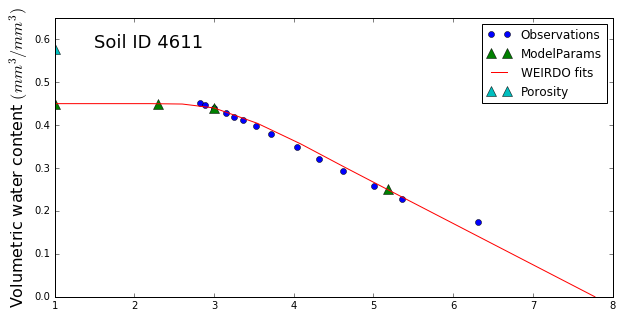

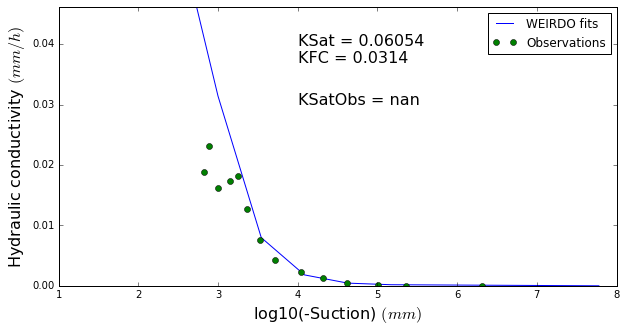

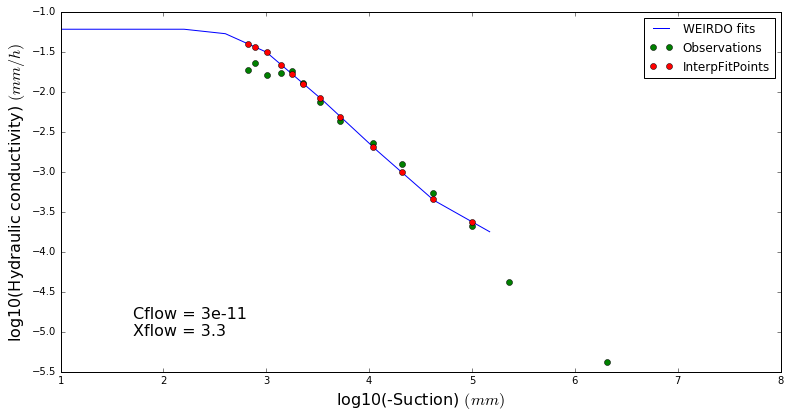

In [45]:
Set = '4611'
FitSAT = 0.45
FitDUL = 0.44
FitLL = 0.25
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,3.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,3.3)

`xtol` termination condition is satisfied.
Function evaluations: 12, initial cost: 2.5243e+00, final cost 6.4172e-02, first-order optimality 7.20e+04.


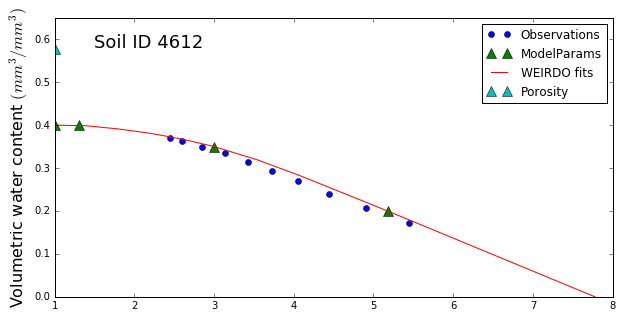

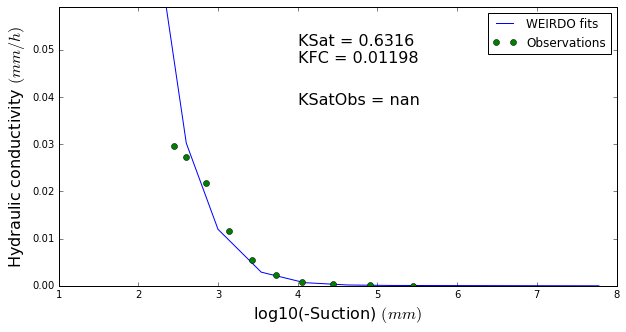

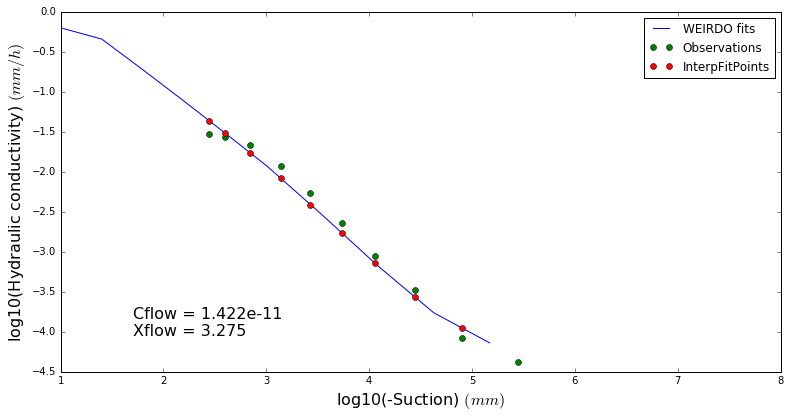

In [46]:
Set = '4612'
FitSAT = 0.4
FitDUL = 0.35
FitLL = 0.20
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

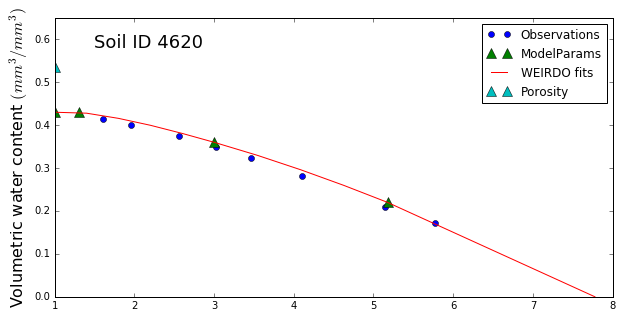

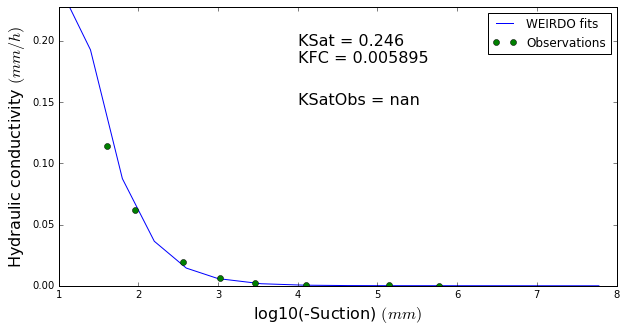

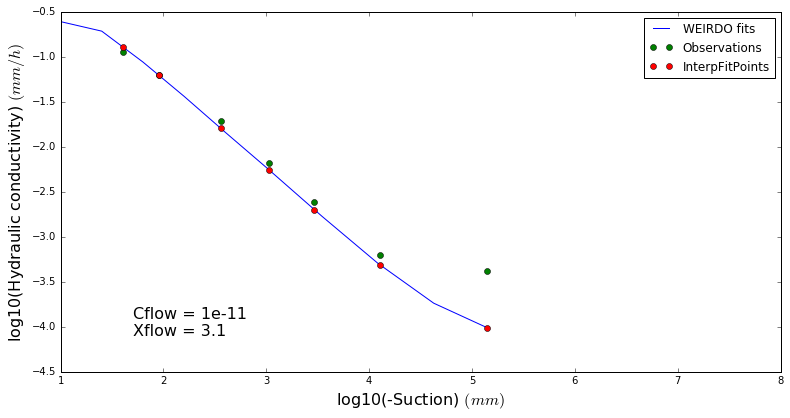

In [47]:
Set = '4620'
FitSAT = 0.43
FitDUL = 0.36
FitLL = 0.22
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,10]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,3.1)

`xtol` termination condition is satisfied.
Function evaluations: 14, initial cost: 5.4103e+00, final cost 1.9115e-01, first-order optimality 1.54e+05.


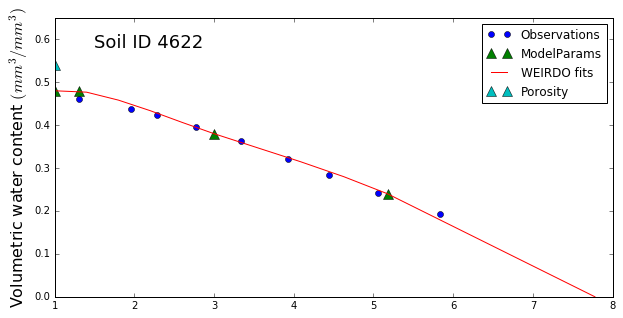

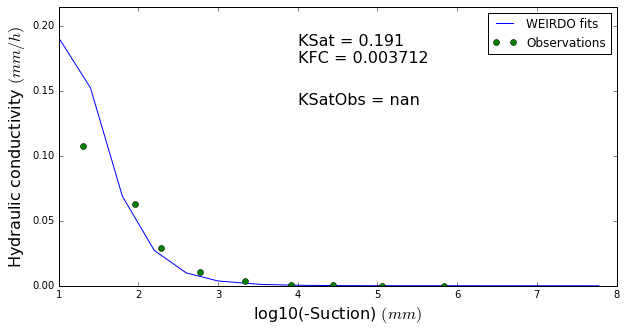

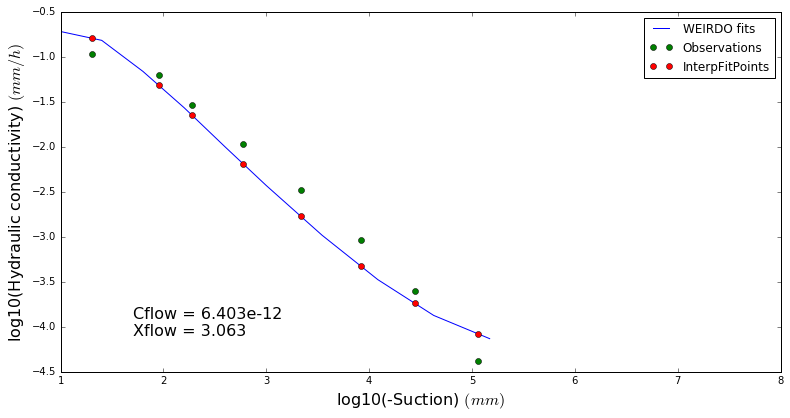

In [48]:
Set = '4622'
FitSAT = 0.48
FitDUL = 0.38
FitLL = 0.24
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [0.001,10]
p0 = [6e-12,1.9]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

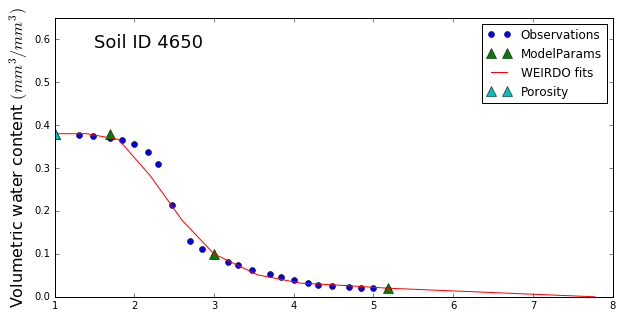

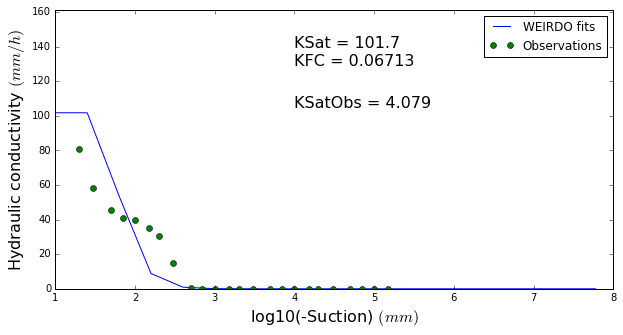

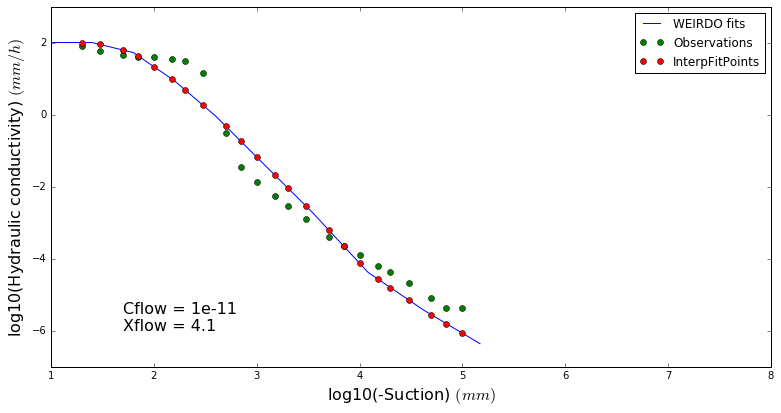

In [49]:
Set = '4650'
FitSAT = 0.38
FitDUL = 0.1
FitLL = 0.02
psibub = -50  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,1.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4.1)

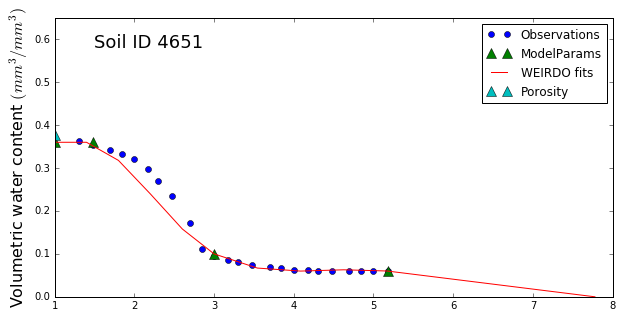

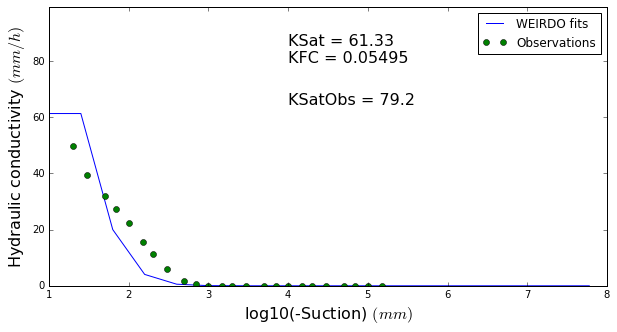

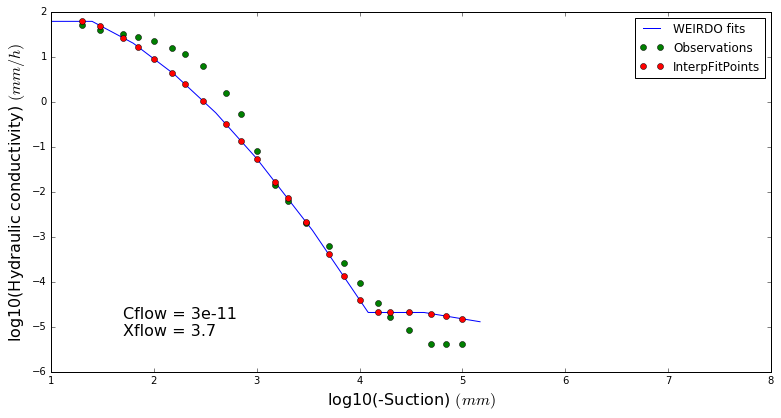

In [50]:
Set = '4651'
FitSAT = 0.36
FitDUL = 0.1
FitLL = 0.06
psibub = -30  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,2.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,3.7)

`xtol` termination condition is satisfied.
Function evaluations: 5, initial cost: 2.8790e+00, final cost 1.2090e+00, first-order optimality 4.02e+01.


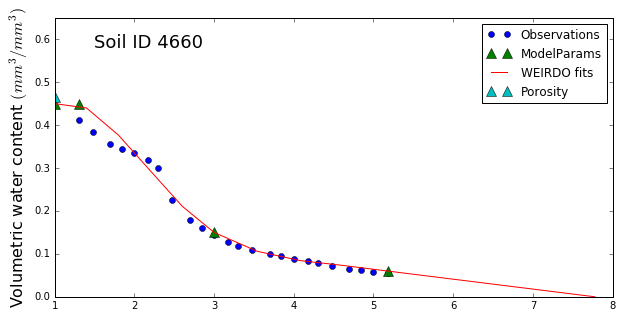

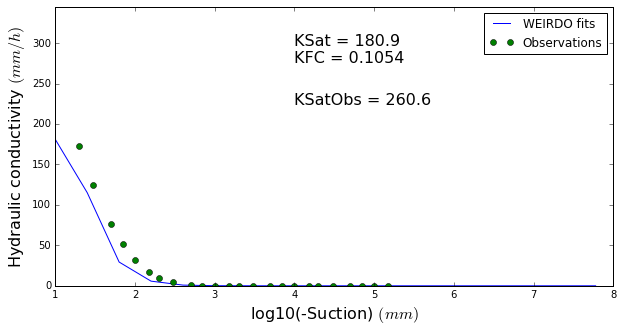

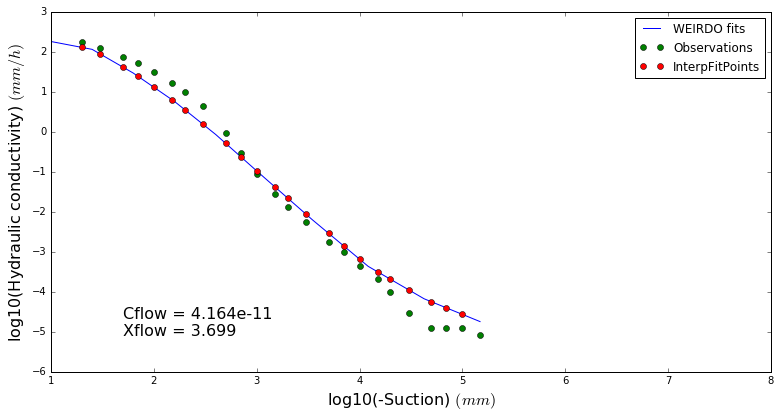

In [51]:
Set = '4660'
FitSAT = 0.45
FitDUL = 0.15
FitLL = 0.06
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

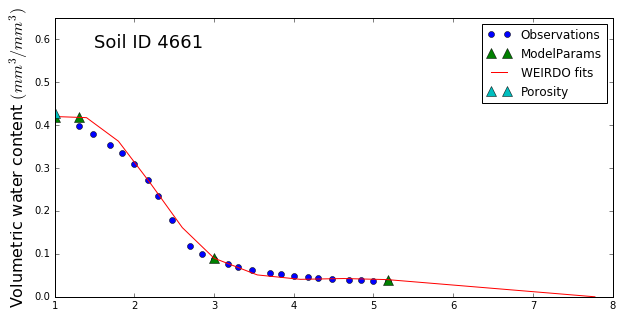

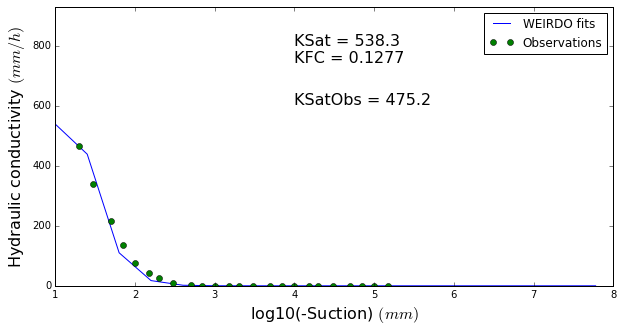

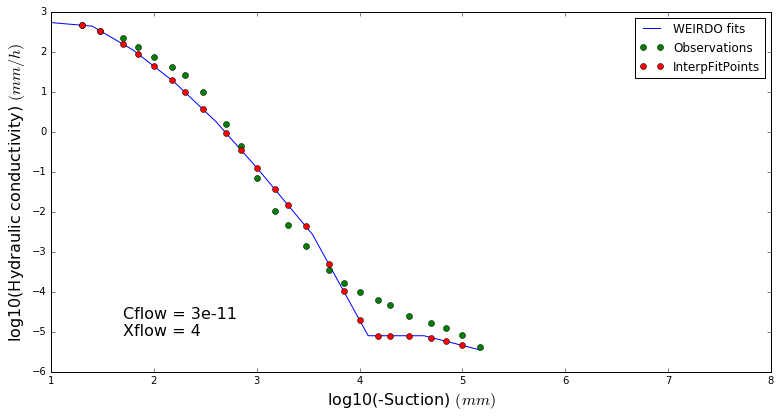

In [52]:
Set = '4661'
FitSAT = 0.42
FitDUL = 0.09
FitLL = 0.04
psibub = -20  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-12,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,3e-11,4)

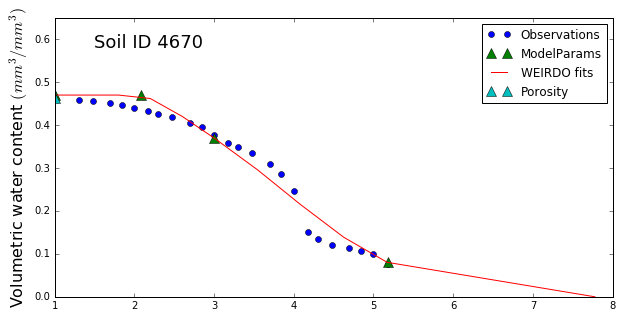

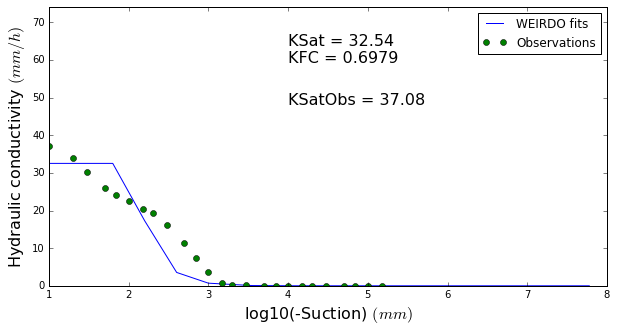

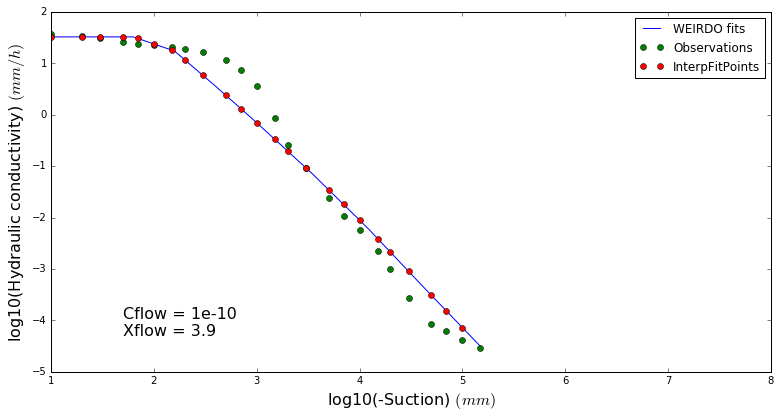

In [53]:
Set = '4670'
FitSAT = 0.47
FitDUL = 0.37
FitLL = 0.08
psibub = -120  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-10,3.9)

`xtol` termination condition is satisfied.
Function evaluations: 9, initial cost: 1.2016e+00, final cost 6.9061e-01, first-order optimality 2.53e+00.


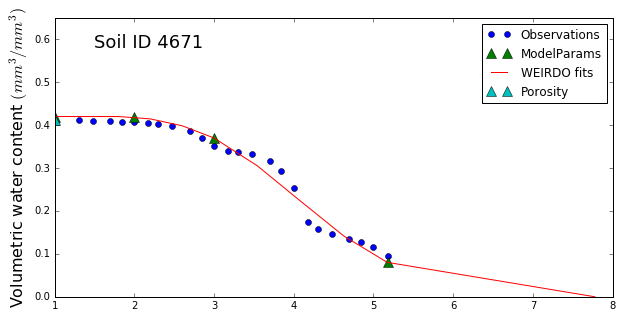

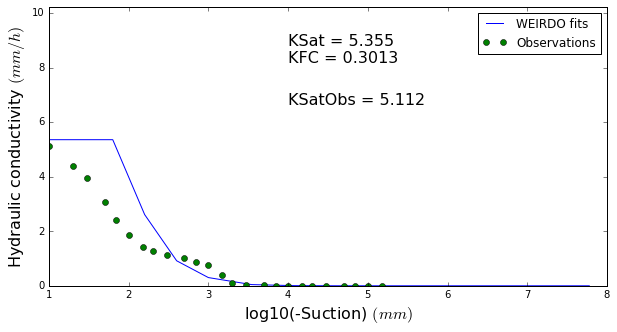

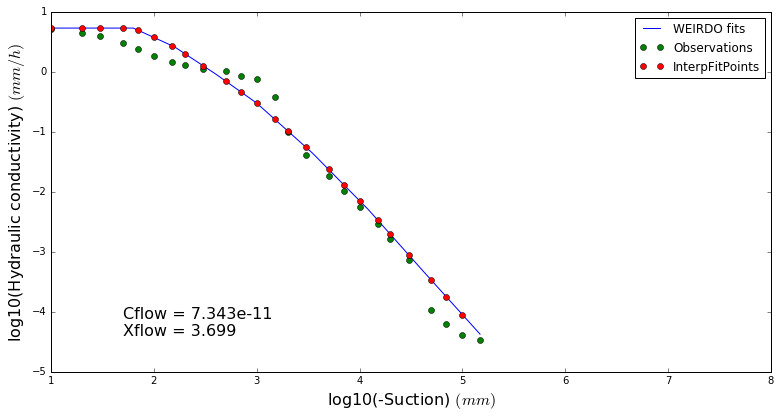

In [54]:
Set = '4671'
FitSAT = 0.42
FitDUL = 0.37
FitLL = 0.08
psibub = -100  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

`xtol` termination condition is satisfied.
Function evaluations: 8, initial cost: 1.2241e+00, final cost 7.4888e-01, first-order optimality 1.68e+01.


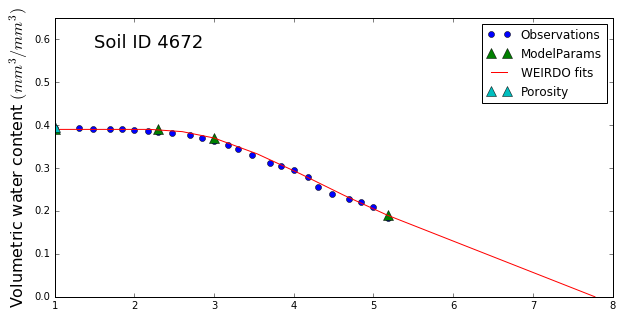

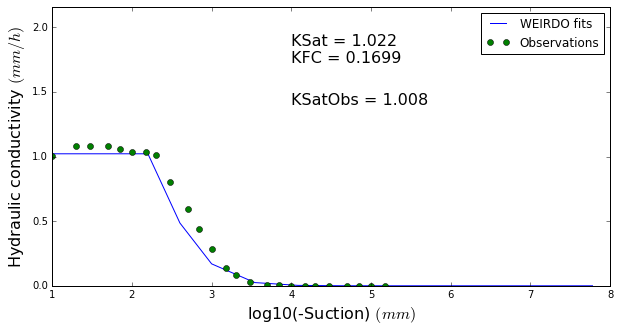

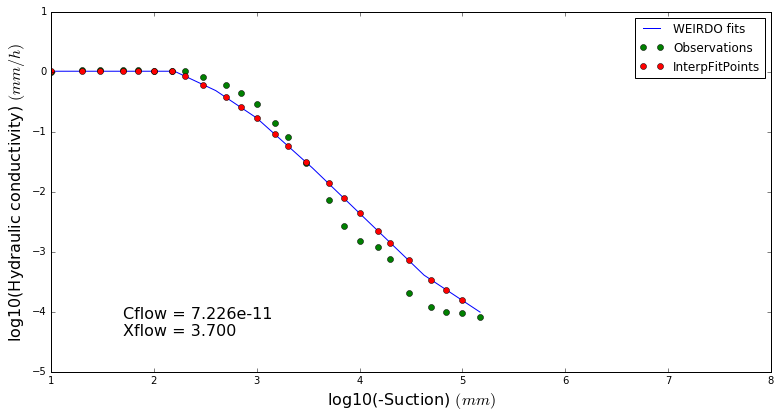

In [55]:
Set = '4672'
FitSAT = 0.39
FitDUL = 0.37
FitLL = 0.19
psibub = -200  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

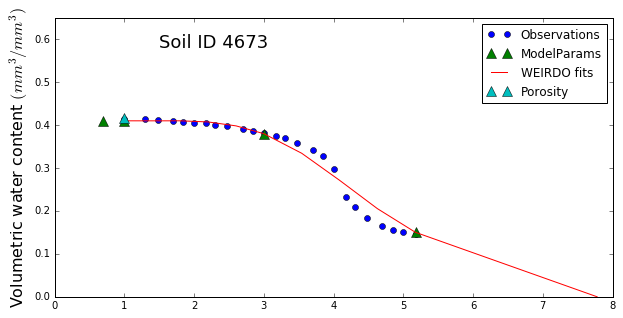

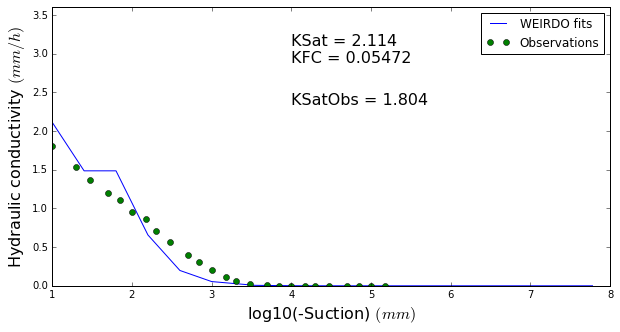

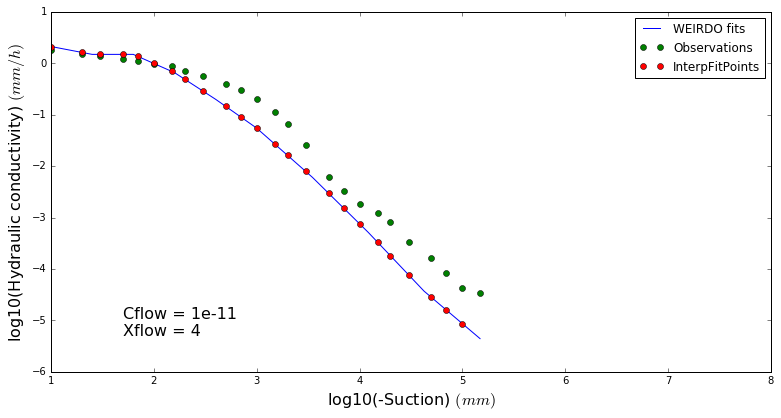

In [56]:
Set = '4673'
FitSAT = 0.41
FitDUL = 0.38
FitLL = 0.15
psibub = -5  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,4.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4)

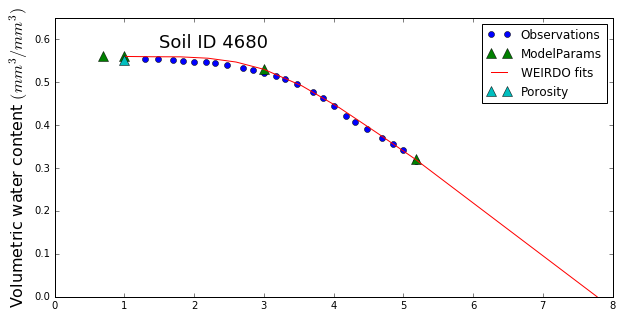

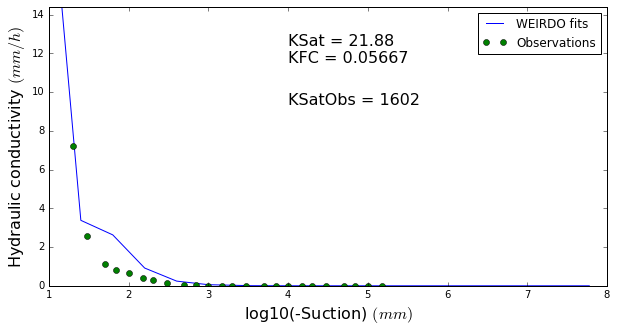

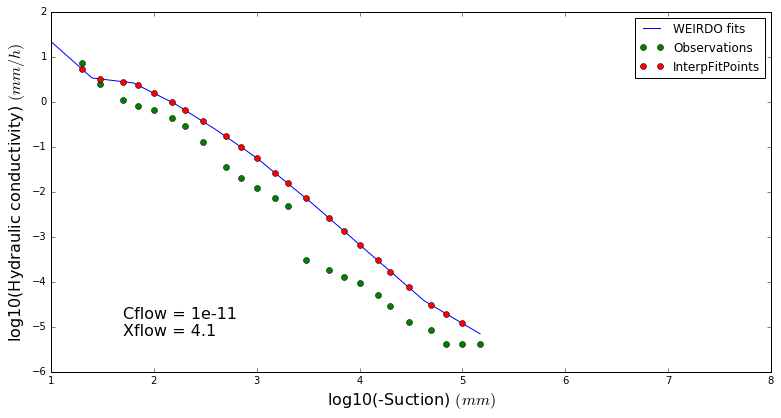

In [57]:
Set = '4680'
FitSAT = 0.56
FitDUL = 0.53
FitLL = 0.32
psibub = -5  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [1.2e-11,0.8]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4.1)

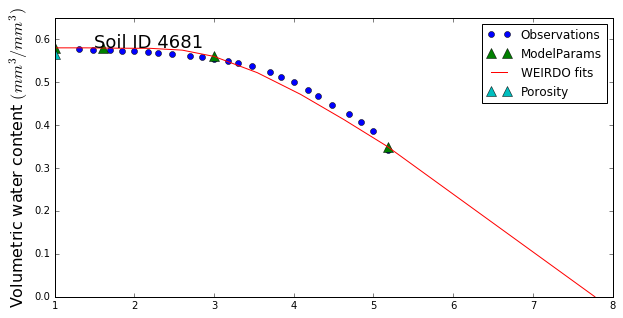

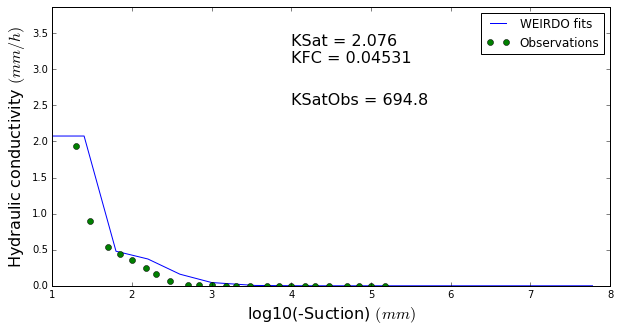

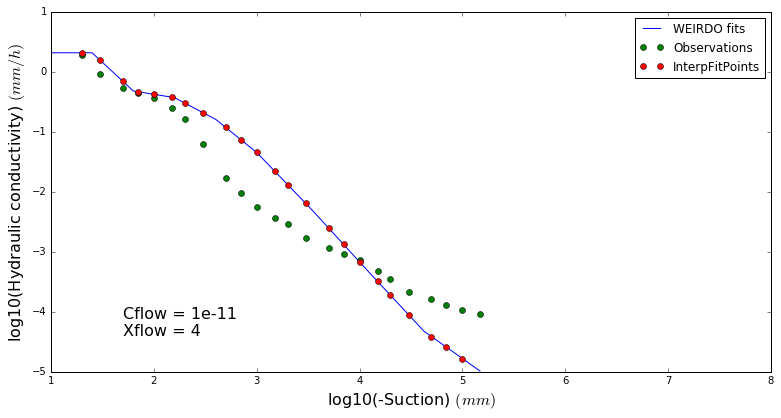

In [58]:
Set = '4681'
FitSAT = 0.58
FitDUL = 0.56
FitLL = 0.35
psibub = -40  #Should be a value between -10 and -600

lower = [0,0]
upper = [.001,10]
p0 = [6e-11,0.7]

#FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)
ForceNGraph(Set,FitSAT,FitDUL,FitLL,psibub,1e-11,4)

In [59]:
Fits.ix[:,'MacroPorosity'] = Fits.ix[:,'SAT'] - Fits.ix[:,'DUL']
Fits.ix[:,'MatrixPorosity'] = Fits.ix[:,'DUL'] - Fits.ix[:,'LL']

In [60]:
Fits

,SAT,DUL,LL,psibub,Cflow,Xflow,Ksat,kFC,kSat,MacroPorosity,MatrixPorosity
2360,0.48,0.455,0.32,-155,1e-10,3.7,NaN,0.161591,2.065475,0.025,0.135
2362,0.557,0.55,0.42,-300,5e-11,3.6,NaN,0.0524529,0.151075,0.007,0.13
4592,0.45,0.38,0.2,-100,5e-12,3.5,NaN,0.00885503,0.235892,0.07,0.18
4600,0.45,0.44,0.27,-200,4.16493e-12,3.375,NaN,0.00439082,0.010023,0.01,0.17
4602,0.45,0.4,0.24,-200,1.43651e-11,2.82252,NaN,0.00665171,0.023683,0.05,0.16
4610,0.55,0.42,0.25,-20,8e-12,3.3,NaN,0.00900174,1.231431,0.13,0.17
4611,0.45,0.44,0.25,-200,3e-11,3.3,NaN,0.031397,0.060541,0.01,0.19
4612,0.4,0.35,0.2,-20,1.42204e-11,3.27534,NaN,0.0119832,0.631566,0.05,0.15
4620,0.43,0.36,0.22,-20,1e-11,3.1,NaN,0.0058948,0.245984,0.07,0.14
4622,0.48,0.38,0.24,-20,6.40289e-12,3.06371,NaN,0.00371162,0.191011,0.1,0.14


In [61]:
np.add(0.5,range(Fits.index.size))

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5])

<Container object of 20 artists>

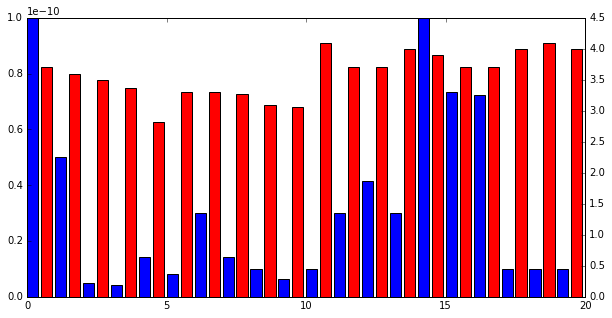

In [62]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.bar(left = range(Fits.index.size),height = Fits.Cflow, width = 0.4)
ax2.bar(left = np.add(0.5,range(Fits.index.size)),height = Fits.Xflow, width = 0.4,color='r')

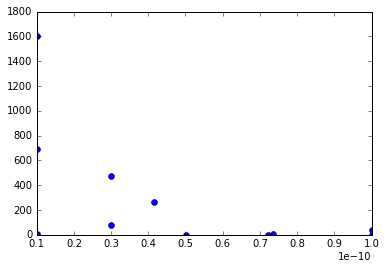

In [63]:
plt.plot(Fits.Cflow,PropsDataFull.k_sat,'o')

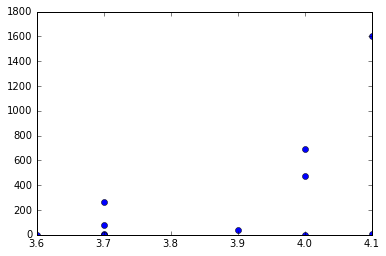

In [64]:
plt.plot(Fits.Xflow,PropsDataFull.k_sat,'o')

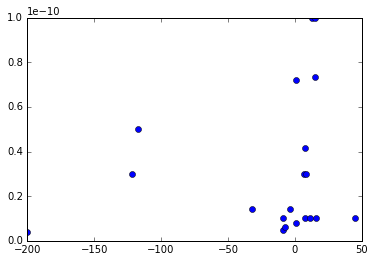

In [65]:
plt.plot(np.log10(Fits.kSat)/Fits.MacroPorosity,Fits.Cflow,'o')

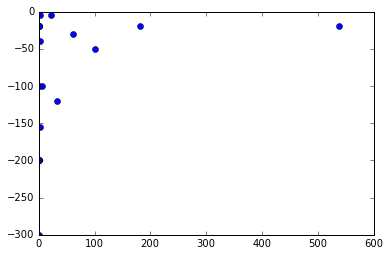

In [66]:
plt.plot(Fits.ix[:,'kSat'],Fits.ix[:,'psibub'],'o')

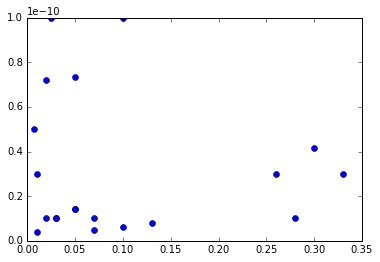

In [67]:
plt.plot(Fits.ix[:,'MacroPorosity'],Fits.ix[:,'Cflow'],'o')

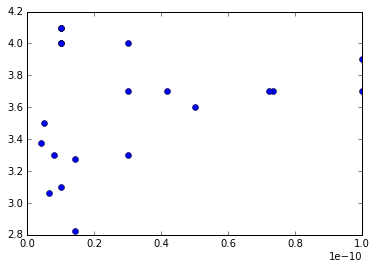

In [68]:
plt.plot(Fits.ix[:,'Cflow'],Fits.ix[:,'Xflow'],'o')

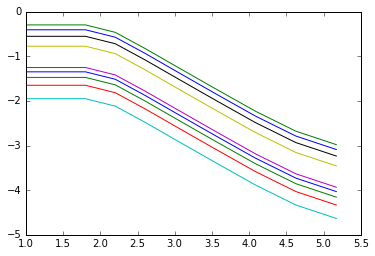

In [69]:
Cflows = [8e-12,6e-12,4e-12,2e-12,1e-11,3e-11,5e-11,7e-11,9e-11]
Xflow = 3
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibub = -100
    
Fig = plt.Figure(figsize=(18,18))
for Cflow in Cflows:
    Frame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    plt.plot(np.log10(-Frame.ix[:,'PsiUpper']),np.log10(Frame.ix[:,'Conductivity']),label = 'WEIRDO fits')

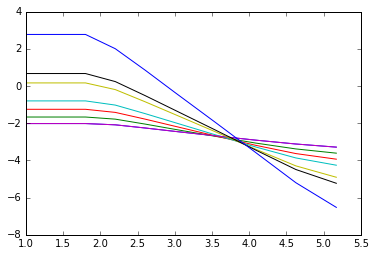

In [151]:
Cflow = 1e-11
Xflows = [2.5,2.75,3,3.25,2.5,3.75,4,5]
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibub = -100
    
Fig = plt.Figure(figsize=(18,18))
for Xflow in Xflows:
    Frame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    plt.plot(np.log10(-Frame.ix[:,'PsiUpper']),np.log10(Frame.ix[:,'Conductivity']),label = 'WEIRDO fits')

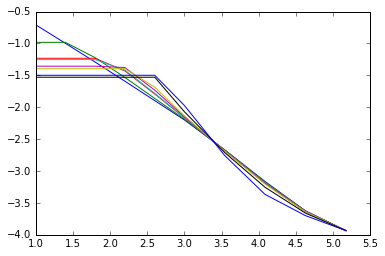

In [71]:
Cflow = 1e-11
Xflow = 3
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibubs = [-10,-30,-90,-100,-150,-200,-400,-600]
    
Fig = plt.Figure(figsize=(18,18))
for psibub in psibubs:
    Frame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    plt.plot(np.log10(-Frame.ix[:,'PsiUpper']),np.log10(Frame.ix[:,'Conductivity']),label = 'WEIRDO fits')

# Bring in Data from Baxters 
### Moisture release data points at kPa potential
### K curve data point at mmH20 potential

In [86]:
Baxters = pd.read_pickle('Baxters.pkl')
Baxters.set_index(['Depth','Site'],inplace=True)
Baxters.sort_index(inplace=True)

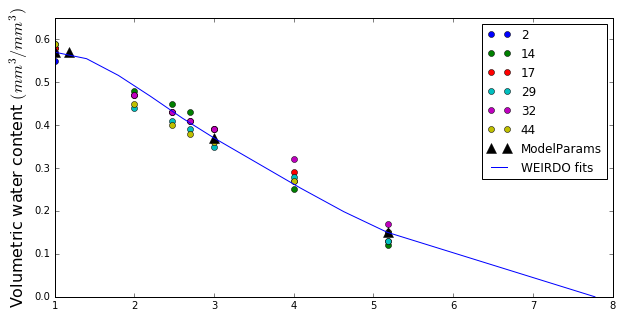

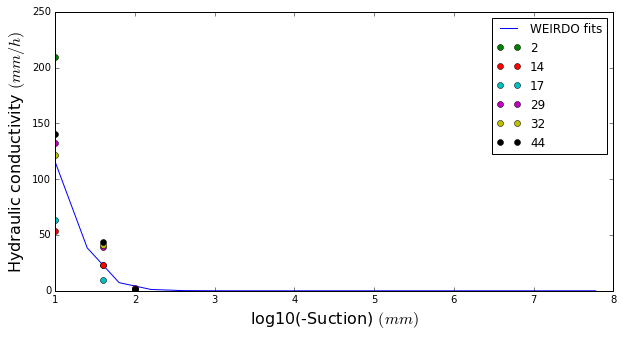

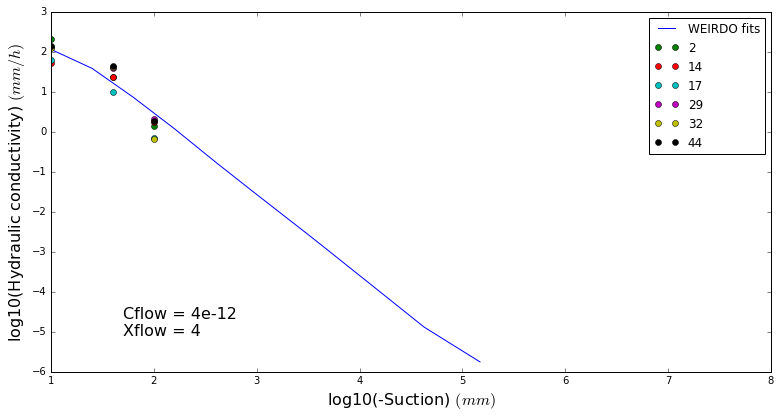

In [159]:
FitSAT = 0.57
FitDUL = 0.37
FitLL = 0.15
psibub = -15
Cflow = 4e-12
Xflow = 4

MRP = [10,100,300,500,1000,10000,150000]
kP = [10,40,100]
MRD = Baxters.ix['0-7.5',Baxters.columns.isin(['VWCSat','VWC1','VWC3','VWC5','VWC10','VWC100','VWC1500'])]
kD = Baxters.ix['0-7.5',Baxters.columns.isin(['k10ms','k40ms','k100ms'])]*3.6e6
FitFrame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

fig = plt.figure(figsize=(10,5))
for samp in MRD.index:
    plt.plot(np.log10(MRP),MRD.ix[samp,:]/100,'o')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*1,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
for samp in kD.index:
    plt.plot(np.log10(kP),kD.ix[samp,:],'o')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.legend()

CoeffPos =  np.log10(FitFrame.ix[:,'Conductivity'].max())*.1
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
for samp in kD.index:
    plt.plot(np.log10(kP),np.log10(kD.ix[samp,:]),'o')
plt.text(0.1,0.1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16, transform=ax.transAxes)
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)

plt.legend()